#### Laurent Jutras-Dubé

## The 3-gene models: stochastic simulations

####   


**1. Stochastic pattern formation with the 3-gene models**

In this notebook, we perform stochastic simulations of the 3-gene models. See the Methods and Supplement for a description of the integration scheme.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

####     

**1.1 The ODEs**

In the following code cell, we define function for the ODEs describing the dynamics of the 3 proteins. We include a diffusion term to model cell-to-cell communication. Note that the time at which diffusion starts in a given cell increases linearly as we move in the posterior direction, so that diffusion starts later in posterior cells than in anterior cells. This helps make the pattern formation process modeled here coherent with somite formation. More details are provided later in this notebook. 

In [2]:
def dynamic(conc, param):
    
    A = conc[:,0]
    B = conc[:,1]
    C = conc[:,2]
    K = param["K"]
    n = param["n"]
       
    dA = 1./(1.+(B/K)**n)
    dB = 1./(1.+(C/K)**n)
    dC = 1./(1.+(A/K)**n)
    
    return np.array([dA, dB, dC]).transpose()



def static(conc, param):
    
    A = conc[:,0]
    B = conc[:,1]
    C = conc[:,2]
    K = param["K"]
    n = param["n"]
       
    dA = 1./(1.+(B/K)**n) *1./(1.+(C/K)**n)
    dB = 1./(1.+(C/K)**n) *1./(1.+(A/K)**n)
    dC = 1./(1.+(A/K)**n) *1./(1.+(B/K)**n)
    
    return np.array([dA, dB, dC]).transpose()



def dif(conc, t, param):
    
    dif = np.zeros(conc.shape)
    D = param["D"]
    n_cells = param["n_cells"]
    v = param["v"]

    dif[0] = D*2.*(conc[1]-conc[0])
    dif[-1] = D*2.*(conc[-2]-conc[-1])
    dif[1:-1] = D*(conc[:-2]-2.*conc[1:-1]+conc[2:])
    
    # Introduce diffusion in the cells at a fixed rate
    x_posterior_psm = int(t*v*n_cells)
    if (x_posterior_psm < n_cells):    
        dif[x_posterior_psm] = D*2.*(conc[x_posterior_psm-1]-conc[x_posterior_psm])
        dif[x_posterior_psm:] = dif[x_posterior_psm]

    return dif



def dconc(conc, g, t, param):
    
    g = np.array([g, g, g]).transpose()
    ng = param["ng"]
    
    return g**ng*dynamic(conc, param) +(1.-g)**ng*static(conc, param) -conc +dif(conc, t, param)

####     

**1.2 The morphogen gradient**

In a given cell, the value of $g$ stays equal to 1 for some time (via the `x_osc` parameter) before decreasing exponentially (via the `s` parameter). To generate a spatial pattern, we make the time at which the value of $g$ starts decreasing, $t^*$, dependent on the position of the cell in the tissue: $t^*(x)$. To model a tissue growing with a constant speed, we make $t^*(x)$ a linear function of $x$, via the `positions` vector and the `v` parameter. In other words, we model a gradient of $g$ with a fixed steepness that moves in the posterior direction at a constant rate. We generate a kymograph showing the spatio-temporal profile of $g$ later in this notebook.

In [3]:
def compute_g(t, param):
    
    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    positions = np.linspace(0.0, 1.0, param["n_cells"])
    
    g = np.exp(s*(positions +x_osc -v*t))
    g[g > 1.] = 1.
    
    return g

####  

**1.3 The Langevin noise**

In the following code cell, we define a function that computes the Langevin noise as described in the Methods and in the Supplement. Note that the factor $dt \: /\sqrt{\Omega}$ is included in the `integrate` function that is defined later in this notebook.

We model a gradient of $g$ with a fixed steepness that moves posteriorly at a rate given by the parameter `v`. This is similar to the somite formation process, during which the tissue grows via the gradual addition of new cells at its posterior end. From this point of view, parameter `v` corresponds to the velocity of elongation of the embryo. To stay coherent with the somitogenesis picture, we start decoupling the noise in a cell from the noise inside the cells posterior to it at that same rate. Therefore, we model the oscillations at the most posterior part of the tissue as being generated by a (noisy) pacemaker cell that "divides" at a fixed rate. In other words, a cell effectively enters the tissue when the noise in its genetic oscillations is not the same as the noise in the genetic oscillations of the (posterior) pacemaker cell.

In [4]:
def compute_noise(conc, g, t, param):
    
    g = np.array([g, g, g]).transpose()
    ng = param["ng"]
    n_cells = param["n_cells"]
    v = param["v"]
    
    normal = np.random.normal(loc=0., scale=1., size=(n_cells, 3))
    std = np.sqrt(g**ng*dynamic(conc, param) +(1.-g)**ng*static(conc, param) +conc)
    noise = normal*std
    
    # Introduce noise in the cells at a fixed rate
    x_posterior_psm = int(t*v*n_cells)
    if (x_posterior_psm < n_cells):    
        noise[x_posterior_psm:] = noise[x_posterior_psm]
    
    return noise

####  

**1.4 The integration scheme**

The `integrate` function requires two inputs:  the initial concentration of the 3 genes at all spatial positions, and the dictionary of parameters. Parameter `n_steps_keep_results` specifies the number of integration steps between which the simulation results are kept. Increasigng this parameter can help reduce the size of the 3 output matrices, `results`, `g_gradient` and `times_plot`. These matrices contain respectively the concentration of the 3 genes at all positions for every time point, the spatio-temporal distribution of parameter $g$ and the array of times. 

There are two main differences with the deterministic `integrate` function:
1. parameter $\Omega$, which represents the typical concentration of proteins, and 
2. the inclusion of a stochastic term proportional to $\frac{dt}{\sqrt{\Omega}}$ when we compute the concentrations at the next time point.

In [5]:
def integrate(init_conc, param):

    # Set the integration parameters
    total_t = param["total_t"]
    dt = param["dt"]
    times = np.arange(0., total_t, dt)

    conc = init_conc
    results = [conc]
    g = compute_g(0., param)
    g_gradient = [g]
    times_plot = [0.]
    
    omega = param["omega"]
    
    counter = 0
    n_steps_keep_results = param["n_steps_keep_results"]
    
    derivative = dconc
    if param["Hill_weights"]:    derivative = dconc_Hill

    
    # Perform the integration
    for t in times[1:]:
        
        conc = conc +derivative(conc, g, t, param)*dt +compute_noise(conc, g, t, param)*np.sqrt(dt/omega)
        conc[conc < 0.] = 0.
        
        g = compute_g(t, param)
           
        counter += 1
        if (counter %n_steps_keep_results == 0):
            results.append(conc)
            g_gradient.append(g)
            times_plot.append(t)
        

    # Output the results
    results = np.array(results)
    g_gradient = np.array(g_gradient)
    times_plot = np.array(times_plot)
    
    return results, g_gradient, times_plot

####  

**1.5 The kymograph plots**

We visualize the results with a kymograph where the $x$ axis is time and the $y$ axis is the position of the cell along the tissue. We represent the concentration of the genes with a purple to blue to white color scheme, where white (blue and purple, resp.) means that gene $A$ ($B$ and $C$, resp.) is predominant in that cell at that time. A cell that contains a mix of the three genes appears grey on the kymograph.

We plot lines representing the moment at which $g$ starts decreasing for the different positions along the tissue. We also plot lines for the moments at which $g$ reaches specific values, namely $0.5$ and $0.2$. To achieve this, we need to define a function `compute_x` that outputs the position of the cell that has a given value of $g$ at a given time, and a function `compute_t` that outputs the time at which $g$ has a given value at a given position along the tissue.

In [6]:
def compute_x(g, t, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return np.log(g)/s -x_osc +v*t



def compute_t(g, x, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return (x_osc +x -np.log(g)/s)/v
    

    
def plot_kymograph(results, g_gradient, times_plot, param):
    
    n_cells = param["n_cells"]
    dt = param["dt"]
    
    plt.rcParams["figure.figsize"] = 6.4,4.8
    fig, ax = plt.subplots()
    
    # Kymograph
    norm = colors.Normalize(vmin=0., vmax=1.)
    ax.imshow(results[:,:,1].transpose(), norm=norm, cmap='PuBu', aspect='auto')
    kymo = ax.imshow(results[:,:,2].transpose(), norm=norm, cmap='BuPu', aspect='auto', alpha=0.5)
    
    # Colorbar
    cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
    cb.ax.tick_params(labelsize=24)
    cb.ax.set_yticklabels(['A', 'B', 'C'])
    
    # Lines of constant g
    ax.plot(n_cells*compute_x(1., times_plot, param), color='k', linewidth=4)
    ax.plot(n_cells*compute_x(0.5, times_plot, param), color='k', linewidth=4)
    ax.plot(n_cells*compute_x(0.2, times_plot, param), color='k', linewidth=4)
    
    ax.text(compute_t(1., 0.15, param)/dt, n_cells*0.15, '$g=1$', rotation=-70, fontsize=24)
    ax.text(compute_t(0.5, 0.15, param)/dt, n_cells*0.15, '$g=0.5$', rotation=-70, fontsize=24)
    ax.text(compute_t(0.2, 0.15, param)/dt, n_cells*0.15, '$g=0.2$', rotation=-70, fontsize=24)
    
    # Other plot options
    ax.set_title('$\Omega=$'+str(int(param["omega"]))+', $D=$'+str(param["D"]), fontsize=32)
    ax.set_xlabel('$t$', fontsize=32)
    ax.set_ylabel('$x$', fontsize=32)
    ax.set_ylim([n_cells, 0])
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.show()

####  

**1.6 The stochastic dynamics of pattern formation in Models 1 and 2, without diffusion**

We define all the required parameters for the ODEs, the morphogen gradient and the integration. We then use the `integrate` function to perform the integration and the `plot_kymograph` function to visualise the results. In Model 1, we set parameter `ng` to 2, while in Model 2, we set `ng` to 1. We first perform stochastic simulations with a typical concentration of 1000 proteins per cell ($\Omega=1000$), without diffusion ($D=0$).

<IPython.core.display.Javascript object>


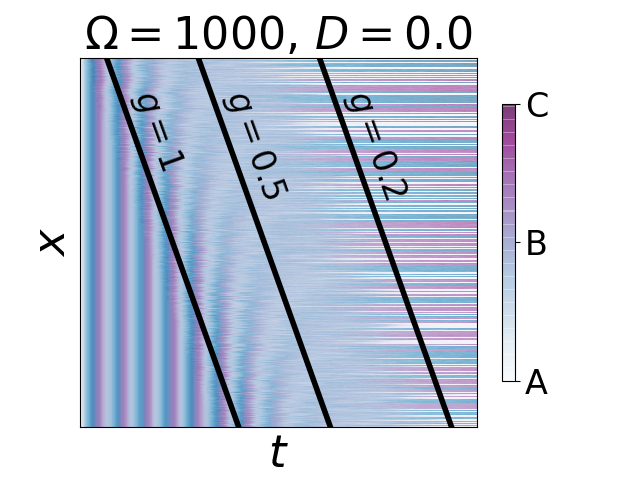

<IPython.core.display.Javascript object>


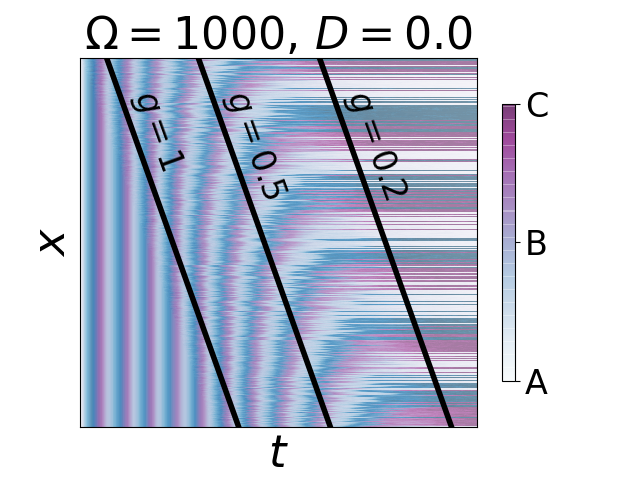

In [7]:
param ={
    
    # ODE parameters
    "K"  : 0.4,
    "n"  : 5,
    "ng" : 2,
    "D"  : 0.,
    
    # Morphogen gradient parameters
    "x_osc"   : 0.2,
    "s"       : 1.,
    "v"       : 0.05,
    "n_cells" : 500,
    
    # Integration parameters
    "total_t"              : 60.,
    "dt"                   : 0.01,
    "n_steps_keep_results" : 1,
    "omega"                : 1000.,
    
    # Hill functions for the weights
    "Hill_weights" : False,
    "Hill_dyn"  : 0.6,
    "Hill_stat" : 0.4
}


init_conc = np.zeros((param["n_cells"], 3))
init_conc[:,0] = 0.75


# Model 1
param["ng"] = 2
results_noise_m1, g_gradient_noise_m1, times_plot_noise_m1 = integrate(init_conc, param)
plot_kymograph(results_noise_m1, g_gradient_noise_m1, times_plot_noise_m1, param)


# Model 2
param["ng"] = 1
results_noise_m2, g_gradient_noise_m2, times_plot_noise_m2 = integrate(init_conc, param)
plot_kymograph(results_noise_m2, g_gradient_noise_m2, times_plot_noise_m2, param)

As expected, the patterns obtained with both models are quite noisy. However, in the stochastic pattern of Model 2 any given region of the simulated tissue is clearly dominated by the gene expression state of the same region in the deterministic pattern. This is not the case for Model 1.

In the next code cell, we plot the concentration of all genes in a single cell as a function of time for both versions of the model. We choose arbitrarily the most anterior cell.

<IPython.core.display.Javascript object>


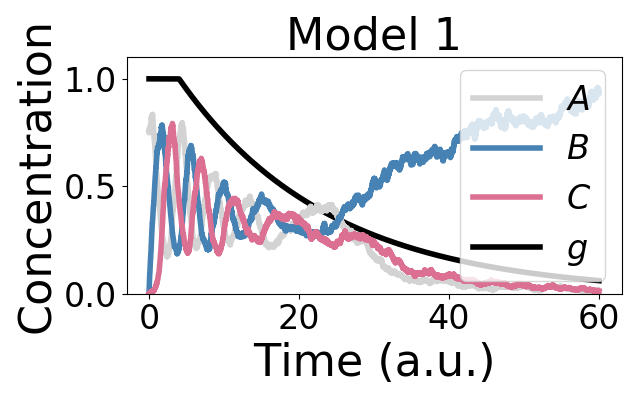

<IPython.core.display.Javascript object>


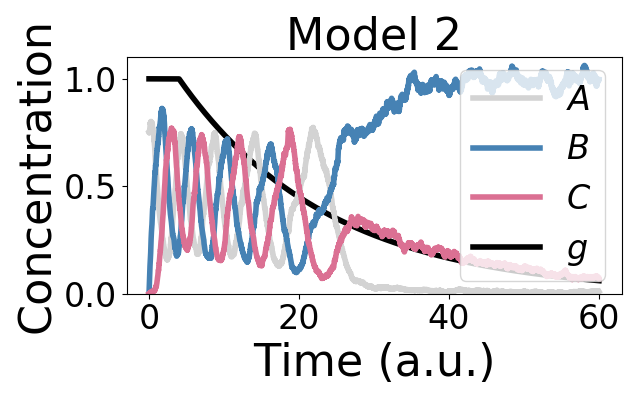

In [8]:
# Model 1
plt.rcParams["figure.figsize"] = 6.4,4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_noise_m1, results_noise_m1[:,0,0], color='lightgrey', lw=4, label='$A$')
ax.plot(times_plot_noise_m1, results_noise_m1[:,0,1], color='steelblue', lw=4, label='$B$')
ax.plot(times_plot_noise_m1, results_noise_m1[:,0,2], color='palevioletred', lw=4, label='$C$')
ax.plot(times_plot_noise_m1, g_gradient_noise_m1[:,0], color='k', lw=4, label='$g$', zorder=0)

# Plot options
ax.set_title('Model 1', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('Time (a.u.)', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_ylim([0., 1.1])
        
fig.tight_layout()
fig.show()



# Model 2
plt.rcParams["figure.figsize"] = 6.4,4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_noise_m2, results_noise_m2[:,0,0], color='lightgrey', lw=4, label='$A$')
ax.plot(times_plot_noise_m2, results_noise_m2[:,0,1], color='steelblue', lw=4, label='$B$')
ax.plot(times_plot_noise_m2, results_noise_m2[:,0,2], color='palevioletred', lw=4, label='$C$')
ax.plot(times_plot_noise_m2, g_gradient_noise_m2[:,0], color='k', lw=4, label='$g$', zorder=0)

# Plot options
ax.set_title('Model 2', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('Time (a.u.)', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_ylim([0., 1.1])
        
fig.tight_layout()
fig.show()

####  

**1.7 The stochastic dynamics of pattern formation in Models 1 and 2, with diffusion**

We perform stochastic simulations with a typical concentration of 1000 proteins per cell ($\Omega=1000$), now with diffusion ($D=0.1$).

<IPython.core.display.Javascript object>


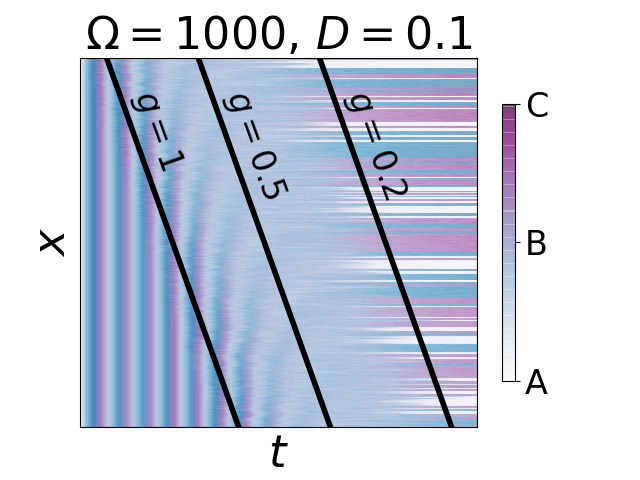

<IPython.core.display.Javascript object>


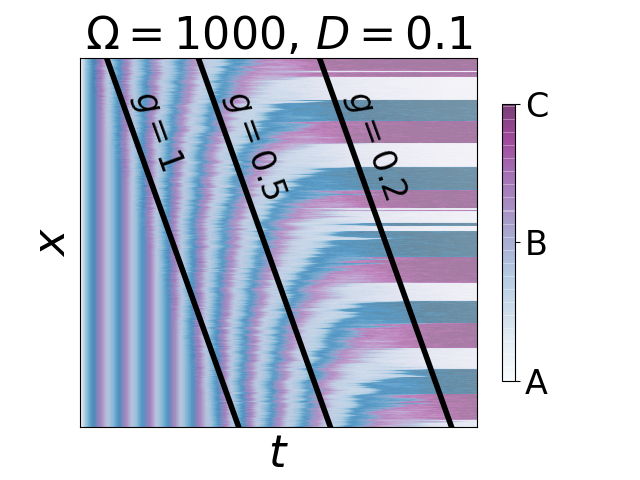

In [9]:
param["D"] = 0.1

# Model 1
param["ng"] = 2
results_noise_dif_m1, g_gradient_noise_dif_m1, times_plot_noise_dif_m1 = integrate(init_conc, param)
plot_kymograph(results_noise_dif_m1, g_gradient_noise_dif_m1, times_plot_noise_dif_m1, param)


# Model 2
param["ng"] = 1
results_noise_dif_m2, g_gradient_noise_dif_m2, times_plot_noise_dif_m2 = integrate(init_conc, param)
plot_kymograph(results_noise_dif_m2, g_gradient_noise_dif_m2, times_plot_noise_dif_m2, param)

As expected, cell-to-cell communication helps fighting the noise in gene expression. From these kymographs, we see that the pattern generated by Model 2 is  better defined than the pattern generated by Model 1. In the next section of this notebook, we quantify the robustness to noise of the two models for different levels of noise and diffusion.

Again, we plot the concentration of all genes in a single cell as a function of time for both versions of the model. We choose arbitrarily the most anterior cell.

<IPython.core.display.Javascript object>


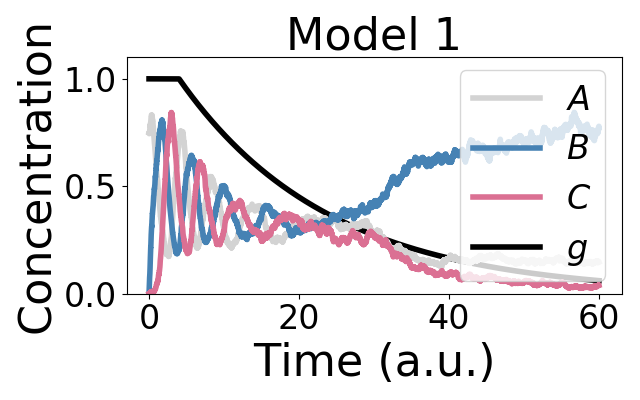

<IPython.core.display.Javascript object>


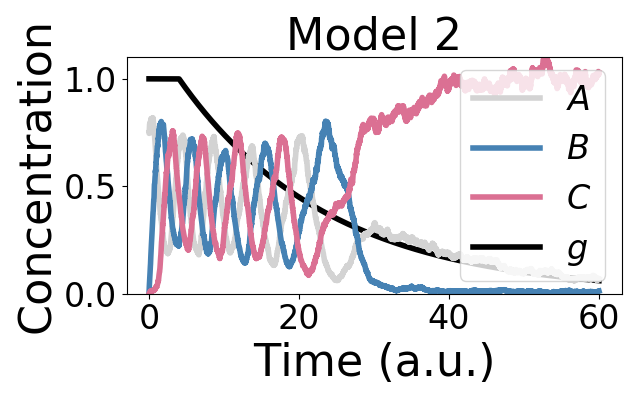

In [10]:
# Model 1
plt.rcParams["figure.figsize"] = 6.4,4.
fig, ax = plt.subplots()

# Trajectory 
ax.plot(times_plot_noise_dif_m1, results_noise_dif_m1[:, 0, 0], color='lightgrey', lw=4, label='$A$')
ax.plot(times_plot_noise_dif_m1, results_noise_dif_m1[:, 0, 1], color='steelblue', lw=4, label='$B$')
ax.plot(times_plot_noise_dif_m1, results_noise_dif_m1[:, 0, 2], color='palevioletred', lw=4, label='$C$')
ax.plot(times_plot_noise_dif_m1, g_gradient_noise_dif_m1[:, 0], color='k', lw=4, label='$g$', zorder=0)

# Plot options
ax.set_title('Model 1', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('Time (a.u.)', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_ylim([0., 1.1])
        
fig.tight_layout()
fig.show()


# Model 2
plt.rcParams["figure.figsize"] = 6.4,4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_noise_dif_m2, results_noise_dif_m2[:, 0, 0], color='lightgrey', lw=4, label='$A$')
ax.plot(times_plot_noise_dif_m2, results_noise_dif_m2[:, 0, 1], color='steelblue', lw=4, label='$B$')
ax.plot(times_plot_noise_dif_m2, results_noise_dif_m2[:, 0, 2], color='palevioletred', lw=4, label='$C$')
ax.plot(times_plot_noise_dif_m2, g_gradient_noise_dif_m2[:, 0], color='k', lw=4, label='$g$', zorder=0)

# Plot options
ax.set_title('Model 2', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('Time (a.u.)', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_ylim([0., 1.1])
        
fig.tight_layout()
fig.show()

####   

In the next code cell, we generate a kymograph showing the spatio-temporal profile of $g$.

<IPython.core.display.Javascript object>


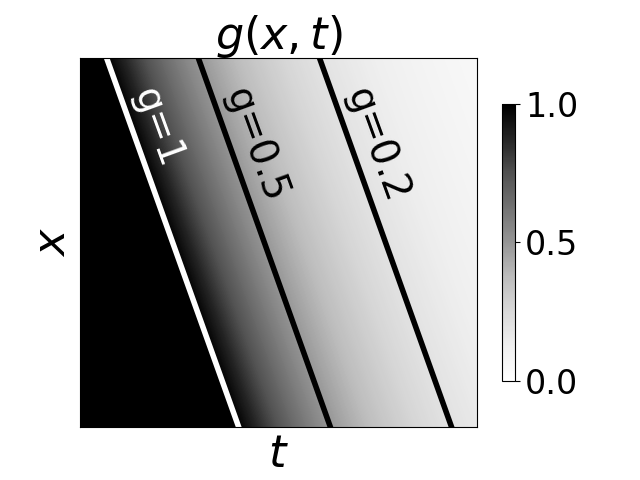

In [11]:
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(g_gradient_noise_m1.transpose(), norm=norm, cmap='Greys', aspect='auto')
 
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
 
# Lines of constant g
ax.plot(param["n_cells"]*compute_x(1., times_plot_noise_m1, param), color='w', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.5, times_plot_noise_m1, param), color='k', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.2, times_plot_noise_m1, param), color='k', linewidth=4)
    
ax.text(compute_t(1., 0.15, param)/param["dt"], param["n_cells"]*0.15, 'g=1', color='w', rotation=-70, fontsize=28)
ax.text(compute_t(0.5, 0.15, param)/param["dt"], param["n_cells"]*0.15, 'g=0.5', rotation=-70, color='k', fontsize=28)
ax.text(compute_t(0.2, 0.15, param)/param["dt"], param["n_cells"]*0.15, 'g=0.2', rotation=-70, color='k', fontsize=28)
    
# Other plot options  
ax.set_title('$g(x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

####  

**1.8 The dynamics of pattern formation in Models 1 and 2 with Hill functions for the weights**

Again, we verify that these results do not depend on the specific functions describing the weights of the dynamic and static modules by repeating the same procedure with Hill functions for the weights, instead of polynomials. To get a Hopf bifurcation (Model 1), we set the Hill treshold of the dynamic module `Hill_dyn` to 0.6, while to get a SNIC bifurcation (Model 2), we set `Hill_dyn` to 0.4. In both models, we set the Hill threshold of the static module `Hill_stat` to 0.4.

In [12]:
def dconc_Hill(conc, g, t, param):
    
    g = np.array([g, g, g]).transpose()
    n = param["n"]
    Hill_dyn = param["Hill_dyn"]
    Hill_stat = param["Hill_stat"]
    
    return (g/Hill_dyn)**n/(1.+(g/Hill_dyn)**n)*dynamic(conc, param) +1./(1.+(g/Hill_stat)**n)*static(conc, param) -conc +dif(conc, t, param)

<IPython.core.display.Javascript object>


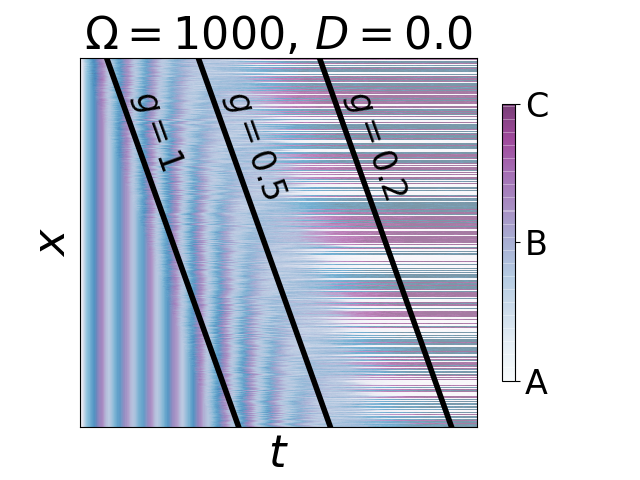

<IPython.core.display.Javascript object>


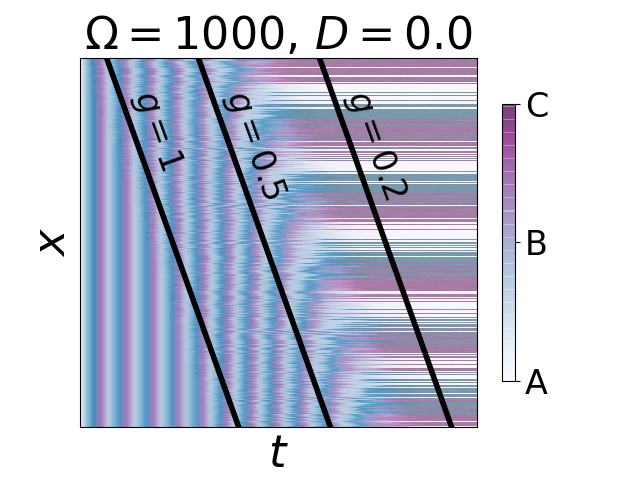

In [13]:
param["D"] = 0.
param["Hill_weights"] = True
param["Hill_stat"] = 0.4

init_conc = np.zeros((param["n_cells"], 3))
init_conc[:,0] = 0.75


# Model 1 (with Hill functions)
param["Hill_dyn"] = 0.6
results_noise_m1_Hill, g_gradient_noise_m1_Hill, times_plot_noise_m1_Hill = integrate(init_conc, param)
plot_kymograph(results_noise_m1_Hill, g_gradient_noise_m1_Hill, times_plot_noise_m1_Hill, param)


# Model 2 (with Hill functions)
param["Hill_dyn"] = 0.4
results_noise_m2_Hill, g_gradient_noise_m2_Hill, times_plot_noise_m2_Hill = integrate(init_conc, param)
plot_kymograph(results_noise_m2_Hill, g_gradient_noise_m2_Hill, times_plot_noise_m2_Hill, param)

<IPython.core.display.Javascript object>


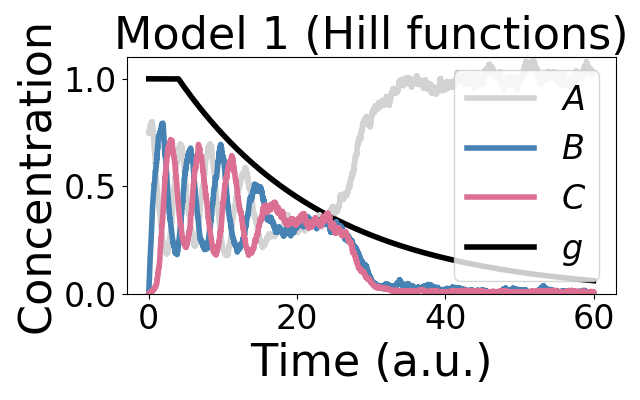

<IPython.core.display.Javascript object>


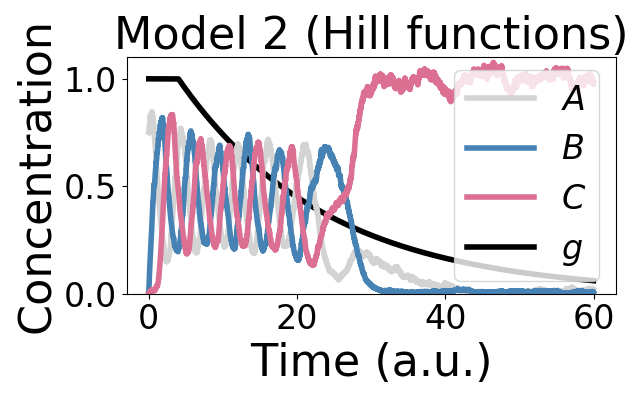

In [14]:
# Model 1 (with Hill functions)
plt.rcParams["figure.figsize"] = 6.4,4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_noise_m1_Hill, results_noise_m1_Hill[:,0,0], color='lightgrey', lw=4, label='$A$')
ax.plot(times_plot_noise_m1_Hill, results_noise_m1_Hill[:,0,1], color='steelblue', lw=4, label='$B$')
ax.plot(times_plot_noise_m1_Hill, results_noise_m1_Hill[:,0,2], color='palevioletred', lw=4, label='$C$')
ax.plot(times_plot_noise_m1_Hill, g_gradient_noise_m1_Hill[:,0], color='k', lw=4, label='$g$', zorder=0)

# Plot options
ax.set_title('Model 1 (Hill functions)', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('Time (a.u.)', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_ylim([0., 1.1])
        
fig.tight_layout()
fig.show()


# Model 2 (with Hill functions)
plt.rcParams["figure.figsize"] = 6.4,4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_noise_m2_Hill, results_noise_m2_Hill[:,0,0], color='lightgrey', lw=4, label='$A$')
ax.plot(times_plot_noise_m2_Hill, results_noise_m2_Hill[:,0,1], color='steelblue', lw=4, label='$B$')
ax.plot(times_plot_noise_m2_Hill, results_noise_m2_Hill[:,0,2], color='palevioletred', lw=4, label='$C$')
ax.plot(times_plot_noise_m2_Hill, g_gradient_noise_m2_Hill[:,0], color='k', lw=4, label='$g$', zorder=0)

# Plot options
ax.set_title('Model 2 (Hill functions)', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('Time (a.u.)', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_ylim([0., 1.1])
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


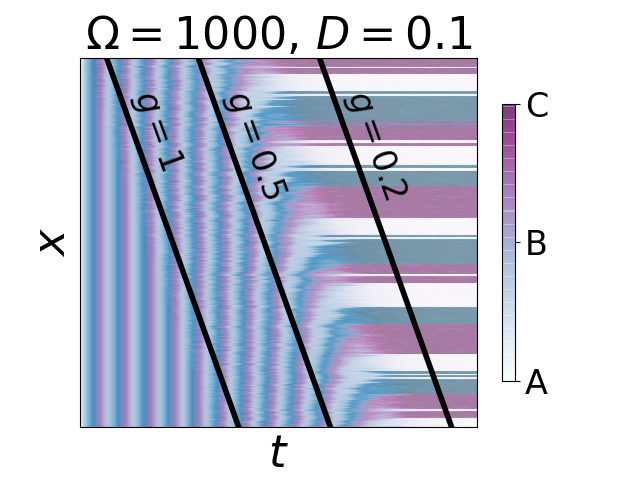

<IPython.core.display.Javascript object>


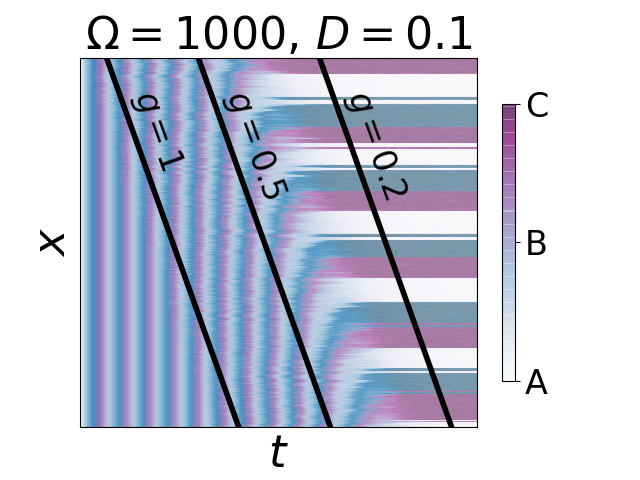

In [15]:
param["D"] = 0.1

# Model 1 (with Hill functions)
param["hill_dyn"] = 0.6
results_noise_dif_m1_Hill, g_gradient_noise_dif_m1_Hill, times_plot_noise_dif_m1_Hill = integrate(init_conc, param)
plot_kymograph(results_noise_dif_m1_Hill, g_gradient_noise_dif_m1_Hill, times_plot_noise_dif_m1_Hill, param)


# Model 2 (with Hill functions)
param["hill_dyn"] = 0.4
results_noise_dif_m2_Hill, g_gradient_noise_dif_m2_Hill, times_plot_noise_dif_m2_Hill = integrate(init_conc, param)
plot_kymograph(results_noise_dif_m2_Hill, g_gradient_noise_dif_m2_Hill, times_plot_noise_dif_m2_Hill,  param)

<IPython.core.display.Javascript object>


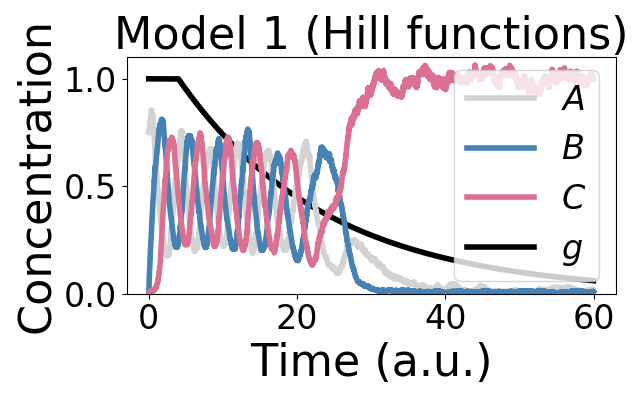

<IPython.core.display.Javascript object>


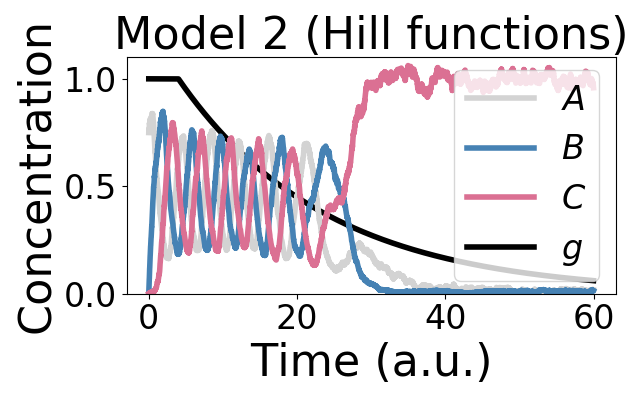

In [16]:
# Model 1 (with Hill functions)
plt.rcParams["figure.figsize"] = 6.4,4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_noise_dif_m1_Hill, results_noise_dif_m1_Hill[:, 0, 0], color='lightgrey', lw=4, label='$A$')
ax.plot(times_plot_noise_dif_m1_Hill, results_noise_dif_m1_Hill[:, 0, 1], color='steelblue', lw=4, label='$B$')
ax.plot(times_plot_noise_dif_m1_Hill, results_noise_dif_m1_Hill[:, 0, 2], color='palevioletred', lw=4, label='$C$')
ax.plot(times_plot_noise_dif_m1_Hill, g_gradient_noise_dif_m1_Hill[:, 0], color='k', lw=4, label='$g$', zorder=0)

# Plot options
ax.set_title('Model 1 (Hill functions)', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('Time (a.u.)', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_ylim([0., 1.1])
        
fig.tight_layout()
fig.show()



# Model 2 (with Hill functions)
plt.rcParams["figure.figsize"] = 6.4,4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_noise_dif_m2_Hill, results_noise_dif_m2_Hill[:, 0, 0], color='lightgrey', lw=4, label='$A$')
ax.plot(times_plot_noise_dif_m2_Hill, results_noise_dif_m2_Hill[:, 0, 1], color='steelblue', lw=4, label='$B$')
ax.plot(times_plot_noise_dif_m2_Hill, results_noise_dif_m2_Hill[:, 0, 2], color='palevioletred', lw=4, label='$C$')
ax.plot(times_plot_noise_dif_m2_Hill, g_gradient_noise_dif_m2_Hill[:, 0], color='k', lw=4, label='$g$', zorder=0)

# Plot options
ax.set_title('Model 2 (Hill functions)', fontsize=32)
ax.legend(loc=5, fontsize=24)
ax.set_xlabel('Time (a.u.)', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_ylim([0., 1.1])
        
fig.tight_layout()
fig.show()

####    

**2. Mutual information**

We now plot the mutual information between the phase along the cycle of genetic oscillations at the beginning of the simulation and the region of the pattern at the end of the simulation. See the Methods and the Supplement for more details.

We first define a function that extracts the data before making the graph. The data is obtained with other python codes that are included in the `Mutual_info_data` folder. We do not include the codes directly in this notebook, since running them can take several hours. In short, we set all cells in the same initial state at the begining of the simulation, i.e. at the same phase of the genetic oscillations. The probability of being in a given region of the pattern is calculated by computing the relative concentration of all genes at the end of the simulation. We repeat this procedure for different initial phases. Since the elongation speed is constant, we sample the initial phases uniformly on the cycle. Because the simulations are stochastic, we repeat the whole procedure several times to get reliable results.

We compute and plot the mutual information for multiple values of the typical concentration $\Omega$ and of the diffusion coefficient $D$. The ideal mutual information is obtained by setting the noise level to 0. Since the deterministic pattern is made of three symmetric regions, its information content is $log(3)$ ~ $1.6$ bits.


####   

**2.1 Extracting the mutual information data**

In the next code cell, we define a function that extracts the data of the mutual information from the `.txt` files found in the `Mutual_info_data` folder. Each file has the mutual information for a given version of the model (Models 1 and 2, and Models 1 and 2 with Hill functions). Therefore, we need to specify the model used to generate the data, via parameter `m_index`.

In [17]:
def extract_mutual_info(m_index):
    
    mutual_info = np.genfromtxt("Mutual_info_data/3-gene_models/3-gene_"
                                +m_index+"_MI.txt", delimiter=",")
    
    return mutual_info.transpose()

####   

**2.2 Generating the mutual information plot**

We first extract the mutual information data. Then, we plot the mutual information as a function of the typical concentration $\Omega$. We plot a different line for each diffusion coefficient $D$ and for each version of the model.

<IPython.core.display.Javascript object>


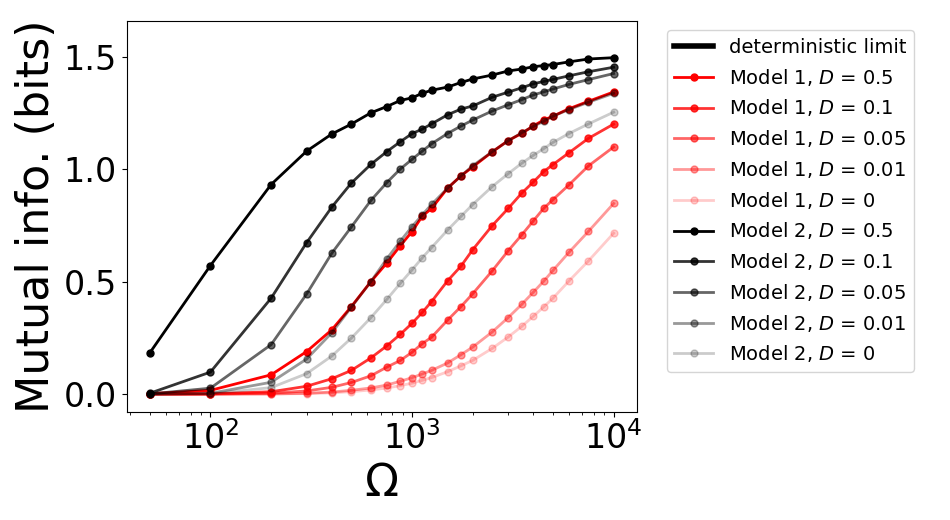

In [18]:
# Extract the mutual information data
MI_m1 = extract_mutual_info('m1')
MI_m2 = extract_mutual_info('m2')


# Plot of the mutual information vs the typical concentration
plt.rcParams["figure.figsize"] = 9.5, 5.2
fig, (ax, legend_ax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios":[2.2,1.]})

# Deterministic limit
ax.semilogx([min(MI_m2[0,1:]), max(MI_m2[0,1:])], [MI_m2[1,0], MI_m2[1,0]], c='k', ls='-', lw=4, label='deterministic limit')

# Model 1
ax.semilogx(MI_m1[0,101:], MI_m1[1,101:], color='r', marker='o', markersize=5, lw=2, label='Model 1, $D$ = 0.5')
ax.semilogx(MI_m1[0,76:100], MI_m1[1,76:100], color='r', alpha=0.8, marker='o', markersize=5, lw=2, label='Model 1, $D$ = 0.1')
ax.semilogx(MI_m1[0,51:75], MI_m1[1,51:75], color='r', alpha=0.6, marker='o', markersize=5, lw=2, label='Model 1, $D$ = 0.05')
ax.semilogx(MI_m1[0,26:50], MI_m1[1,26:50], color='r', alpha=0.4, marker='o', markersize=5, lw=2, label='Model 1, $D$ = 0.01')
ax.semilogx(MI_m1[0,1:25], MI_m1[1,1:25], color='r', alpha=0.2, marker='o', markersize=5, lw=2, label='Model 1, $D$ = 0')

# # Model 2
ax.semilogx(MI_m2[0,101:], MI_m2[1,101:], color='k', marker='o', markersize=5, lw=2, label='Model 2, $D$ = 0.5')
ax.semilogx(MI_m2[0,76:100], MI_m2[1,76:100], color='k', alpha=0.8, marker='o', markersize=5, lw=2, label='Model 2, $D$ = 0.1')
ax.semilogx(MI_m2[0,51:75], MI_m2[1,51:75], color='k', alpha=0.6, marker='o', markersize=5, lw=2, label='Model 2, $D$ = 0.05')
ax.semilogx(MI_m2[0,26:50], MI_m2[1,26:50], color='k', alpha=0.4, marker='o', markersize=5, lw=2, label='Model 2, $D$ = 0.01')
ax.semilogx(MI_m2[0,1:25], MI_m2[1,1:25], color='k', alpha=0.2, marker='o', markersize=5, lw=2, label='Model 2, $D$ = 0')

# Legend
legend_handles, legend_labels = ax.get_legend_handles_labels()
legend_ax.legend(legend_handles, legend_labels, fontsize=14)
legend_ax.axis("off")

# Other plot options
ax.set_xlabel('$\Omega$', fontsize=32)
ax.set_ylabel('Mutual info. (bits)', fontsize=32)
ax.tick_params(labelsize=24)
               
fig.tight_layout()
fig.show()

As expected, the mutual information increases as the level of noise decreases (via an increase of the typical protein concentration $\Omega$). The mutual information also increases as we increase the strength of cell-to-cell coupling (via an increase of the diffusion coefficient $D$), which confirms the observations made on the kymographs. Importantly, for a given level of noise and cell-to-cell coupling the mutual information of Model 2 is always higher than the mutual information of Model 1. In the next code cell, we confirm those results with the 3-gene models with Hill functions for the weights of the dynamic and static terms.

<IPython.core.display.Javascript object>


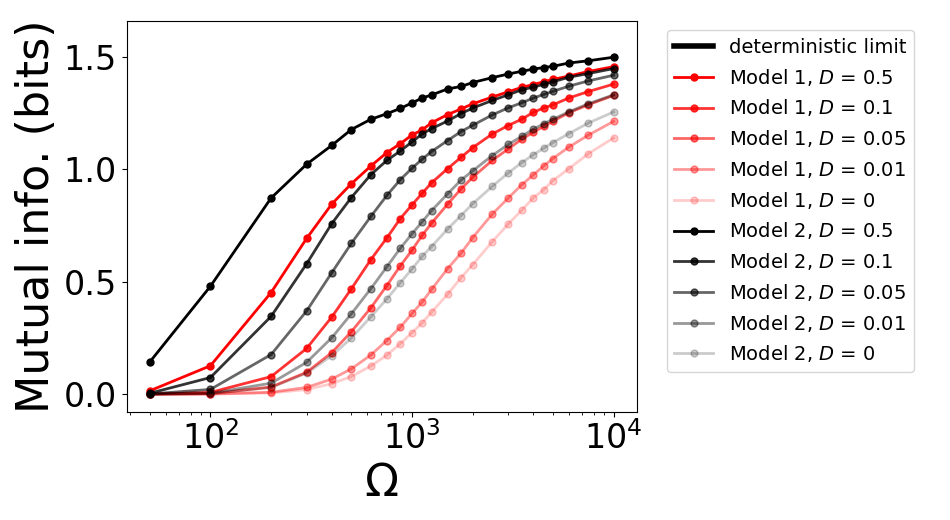

In [19]:
# Extract the mutual information data
MI_m1_Hill = extract_mutual_info('m1_Hill')
MI_m2_Hill = extract_mutual_info('m2_Hill')


# Plot of the mutual information vs the typical concentration
plt.rcParams["figure.figsize"] = 9.5, 5.2
fig, (ax, legend_ax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios":[2.2,1.]})

# Deterministic limit
ax.semilogx([min(MI_m2_Hill[0,1:]), max(MI_m2_Hill[0,1:])], [MI_m2_Hill[1,0], MI_m2_Hill[1,0]], c='k', ls='-', lw=4, label='deterministic limit')

# Model 1
ax.semilogx(MI_m1_Hill[0,101:], MI_m1_Hill[1,101:], color='r', marker='o', markersize=5, lw=2, label='Model 1, $D$ = 0.5')
ax.semilogx(MI_m1_Hill[0,76:100], MI_m1_Hill[1,76:100], color='r', alpha=0.8, marker='o', markersize=5, lw=2, label='Model 1, $D$ = 0.1')
ax.semilogx(MI_m1_Hill[0,51:75], MI_m1_Hill[1,51:75], color='r', alpha=0.6, marker='o', markersize=5, lw=2, label='Model 1, $D$ = 0.05')
ax.semilogx(MI_m1_Hill[0,26:50], MI_m1_Hill[1,26:50], color='r', alpha=0.4, marker='o', markersize=5, lw=2, label='Model 1, $D$ = 0.01')
ax.semilogx(MI_m1_Hill[0,1:25], MI_m1_Hill[1,1:25], color='r', alpha=0.2, marker='o', markersize=5, lw=2, label='Model 1, $D$ = 0')

# # Model 2
ax.semilogx(MI_m2_Hill[0,101:], MI_m2_Hill[1,101:], color='k', marker='o', markersize=5, lw=2, label='Model 2, $D$ = 0.5')
ax.semilogx(MI_m2_Hill[0,76:100], MI_m2_Hill[1,76:100], color='k', alpha=0.8, marker='o', markersize=5, lw=2, label='Model 2, $D$ = 0.1')
ax.semilogx(MI_m2_Hill[0,51:75], MI_m2_Hill[1,51:75], color='k', alpha=0.6, marker='o', markersize=5, lw=2, label='Model 2, $D$ = 0.05')
ax.semilogx(MI_m2_Hill[0,26:50], MI_m2_Hill[1,26:50], color='k', alpha=0.4, marker='o', markersize=5, lw=2, label='Model 2, $D$ = 0.01')
ax.semilogx(MI_m2_Hill[0,1:25], MI_m2_Hill[1,1:25], color='k', alpha=0.2, marker='o', markersize=5, lw=2, label='Model 2, $D$ = 0')

# Legend
legend_handles, legend_labels = ax.get_legend_handles_labels()
legend_ax.legend(legend_handles, legend_labels, fontsize=14)
legend_ax.axis("off")

# Other plot options
ax.set_xlabel('$\Omega$', fontsize=32)
ax.set_ylabel('Mutual info. (bits)', fontsize=32)
ax.tick_params(labelsize=24)
               
fig.tight_layout()
fig.show()